# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Experiment 1: evaluation on artificial datsa

#### Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid

import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle

The next part of experiment 1 will be here after overcoming technical difficulties...

### Experiment 2: Real-world use case: predicting survival of patients with heart failure

#### Preparing data and deep model

In [2]:
df_train = pd.read_csv('data/exp3_heart_failure_dataset.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
10,75.0,1,81,0,38,1,368000.00,4.0,131,1,1,10,1


In [3]:
cols_standardize = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cols_leave = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [92]:
model.duration_index

array([  0.        ,  31.11111111,  62.22222222,  93.33333333,
       124.44444444, 155.55555556, 186.66666667, 217.77777778,
       248.88888889, 280.        ])

In [96]:
max(y_train[1])

1.0

In [4]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [5]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['DEATH_EVENT'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [7]:
x_train.shape

(191, 11)

In [11]:
events_test

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0])

In [12]:
labtrans.out_features

10

#### Training deep model

In [79]:
in_features = x_train.shape[1]
num_nodes = [8, 8]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.6

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [80]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=11, out_features=8, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.6, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=8, out_features=8, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.6, inplace=False)
    )
    (2): Linear(in_features=8, out_features=10, bias=True)
  )
)

In [85]:
model = DeepHitSingle(net, tt.optim.Adam(0.1), duration_index=labtrans.cuts)

In [89]:
batch_size = 64
epochs = 10000
callbacks = [tt.cb.EarlyStopping()]

In [90]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

13:	[0s / 0s],		train_loss: 0.4030,	val_loss: 0.3924
14:	[0s / 0s],		train_loss: 0.3927,	val_loss: 0.4009
15:	[0s / 0s],		train_loss: 0.3620,	val_loss: 0.4085
16:	[0s / 0s],		train_loss: 0.3872,	val_loss: 0.4122
17:	[0s / 0s],		train_loss: 0.3634,	val_loss: 0.4118
18:	[0s / 0s],		train_loss: 0.3519,	val_loss: 0.4114
19:	[0s / 0s],		train_loss: 0.3652,	val_loss: 0.4107
20:	[0s / 0s],		train_loss: 0.3504,	val_loss: 0.4150
21:	[0s / 0s],		train_loss: 0.3558,	val_loss: 0.4186
22:	[0s / 0s],		train_loss: 0.3501,	val_loss: 0.4193
23:	[0s / 0s],		train_loss: 0.3601,	val_loss: 0.4197


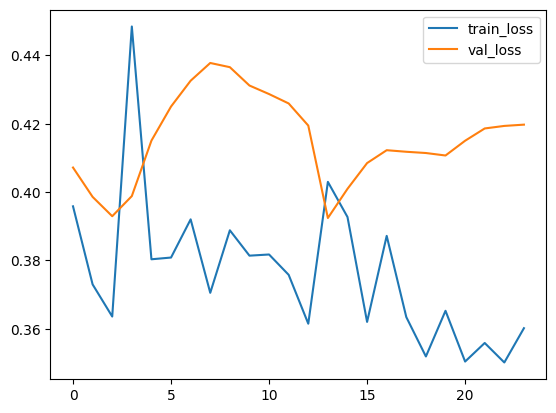

In [91]:
_ = log.plot()

#### Preparing data and non-deep models 

In [2]:
real_data = pd.read_csv("data/exp3_heart_failure_dataset.csv")
real_data.rename(columns={"DEATH_EVENT": "event"}, inplace=True)

In [3]:
from sksurv.util import Surv
X = real_data[["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", 
                "serum_creatinine", "serum_sodium", "sex", "smoking"]]
y = Surv.from_dataframe("event", "time", real_data)

In [4]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(random_state=42, n_estimators=120, max_depth=8, min_samples_leaf=4, max_features=3)
rsf.fit(X, y)
rsf.score(X, y)

0.8758763084605781

#### Creating explanations

In [6]:
from survshap import SurvivalModelExplainer, ModelSurvSHAP
from survlime import SurvLIME
rsf_exp = SurvivalModelExplainer(rsf, X, y)

In [7]:
exp3_survshap_global_rsf = ModelSurvSHAP(random_state=42)
exp3_survshap_global_rsf.fit(rsf_exp)

100%|██████████| 299/299 [32:46<00:00,  6.58s/it]


In [9]:
with open("pickles/exp3_survshap_global_rsf", "wb") as f:
    pickle.dump(exp3_survshap_global_rsf, f)

In [10]:
n_obs = len(X)
sls = [None for i in range(n_obs)]
funcs_dist = [None for i in range(n_obs)]
for i in tqdm(range(n_obs)):
    survlime = SurvLIME(N=1000)
    survlime.fit(rsf_exp, X.iloc[[i]], k=2, timestamps=rsf.predict_survival_function(X.iloc[[0]])[0].x)
    sls[i] = survlime

100%|██████████| 299/299 [04:00<00:00,  1.24it/s]


In [11]:
with open("pickles/exp3_survlime_global_rsf", "wb") as f:
    pickle.dump(sls, f)

#### Results analysis

In [12]:
with open("pickles/exp3_survshap_global_rsf", "rb") as f:
    exp3_survshap_global_rsf = pickle.load(f)

In [14]:
with open("pickles/exp3_survlime_global_rsf", "rb") as f:
    exp3_survlime_global_rsf = pickle.load(f)

##### Plot examples

In [15]:
example_rsf = exp3_survshap_global_rsf.individual_explanations[12]

In [16]:
melted_example_rsf = pd.melt(example_rsf.result, id_vars="variable_name", value_vars=example_rsf.result.columns[6:])
melted_example_rsf["variable"] = melted_example_rsf["variable"].str[4:].astype(float)
melted_example_rsf.to_csv("results/exp3_example_rsf.csv", index=False)
example_rsf.simplified_result.to_csv("results/exp3_example_rsf_agg.csv", index=False)

In [17]:
example_rsf2 = exp3_survshap_global_rsf.individual_explanations[14]
melted_example_rsf_2 = pd.melt(example_rsf2.result, id_vars="variable_name", value_vars=example_rsf2.result.columns[6:])
melted_example_rsf_2["variable"] = melted_example_rsf_2["variable"].str[4:].astype(float)
melted_example_rsf_2.to_csv("results/exp3_example_rsf_2.csv", index=False)

##### Importance rankings

In [18]:
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

from scipy.stats import weightedtau
def mean_weighted_tau(ranks1, ranks2):
    taus = [None] * 100
    for i in range(100):
        tau, _ = weightedtau(ranks1.iloc[i], ranks2.iloc[i])
        taus[i] = tau
    return np.mean(taus), np.std(taus)

def prepare_ranking_summary_long(ordering):
    res = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5, 6, 7])
    for i in range(8):
        tmp = pd.DataFrame(ordering[i].value_counts().to_dict(), index=[i+1])
        res = pd.concat([res, tmp])
    res = res.reset_index().rename(columns=dict(zip([i for i in range(8)] + ["index"], X.columns.to_list() + ["importance_ranking"])))
    return res.melt(id_vars=["importance_ranking"], value_vars=X.columns)

In [19]:
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

def get_orderings_and_ranks_lime(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result
        df["impact"] = df["variable_value"] * df["coefficient"] 
        importance_orderings.append(df.sort_values(by="impact", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.impact).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

In [20]:
rsf_survshap_orderings, rsf_survshap_ranks = get_orderings_and_ranks_shap(exp3_survshap_global_rsf.individual_explanations)
prepare_ranking_summary_long(rsf_survshap_orderings).to_csv("results/exp3_survshap_orderings_rsf.csv")

#### Calculating permutational variable importance

In [23]:
from sksurv.metrics import brier_score, integrated_brier_score
# mask created to enable for calculating Brier score
mask = (y["time"] < y[y["event"]==1]["time"].max()) & (y["time"] > y[y["event"]==1]["time"].min())
times = np.unique(np.percentile(y[mask]["time"], np.linspace(0.1, 99.9, 101)))

np.unique(np.percentile(y[mask]["time"], np.linspace(0.1, 99.9, 101)))
def loss_integrated_brier_score(model, data, y):
    sfs = model.predict_survival_function(data)
    sfs = [sf(times) for sf in sfs] 
    result = integrated_brier_score(y, y, sfs, times)
    return 1-result

In [24]:
from sklearn.inspection import permutation_importance
imp_mean_rsf = permutation_importance(rsf, X, y, 
                    scoring = loss_integrated_brier_score, n_repeats=100, random_state=42)["importances_mean"]

In [25]:
pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

,0,1
2,ejection_fraction,0.045645
4,serum_creatinine,0.045391
0,age,0.031623
5,serum_sodium,0.012024
3,platelets,0.011392
1,creatinine_phosphokinase,0.011368
6,sex,0.002585
7,smoking,0.002113


In [26]:
rsf_survlime_orderings, rsf_survlime_ranks = get_orderings_and_ranks_lime(exp3_survlime_global_rsf)

In [27]:
prepare_ranking_summary_long(rsf_survlime_orderings).to_csv("results/exp3_survlime_orderings_rsf.csv")

#### Explaining deep model's predictions

In [ ]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
)

In [ ]:
model.eval()
# baseline_dist = torch.zeros(191, 11, requires_grad=True) * 0.001
inputs = torch.tensor(x_train, requires_grad=True) #.unsqueeze(dim=0)
outputs = torch.tensor(y_train[1].astype('int64')) #, requires_grad=True)
dl = DeepLift(model.net)
ig = IntegratedGradients(model.net)
attributions, delta = ig.attribute(inputs, target=outputs, return_convergence_delta=True) #  baseline_dist, target=outputs,
print('Integrated Gradients mean attributions:', attributions.mean(dim=0).detach().numpy())
print('Mean Convergence Delta:', delta.mean().detach().numpy())
attributions, delta = dl.attribute(inputs, target=outputs, return_convergence_delta=True) #  baseline_dist, target=outputs,
print('DeepLift mean attributions:', attributions.mean(dim=0).detach().numpy())
print('Mean Convergence Delta:', delta.mean().detach().numpy())

We got the following results:

Integrated Gradients mean attributions: [ 0.0292784   0.02505408 -0.03815171  0.01266383  0.01597387  0.06627826
 -0.03912117 -0.02868438  0.06274574  0.03201562  0.00618445]

DeepLift mean attributions: [ 0.02618182  0.01984281 -0.03617777  0.0109012   0.01511144  0.06467749
 -0.03416074 -0.02320135  0.05641534  0.03421191  0.00955333]

#### Comparison of different explaining methods

In [37]:
X.columns

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking'],
      dtype='object')

In [38]:
df_train.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [40]:
ig_results = [
    0.0292784,
    0.02505408,
    0.03815171,
    0.01266383,
    0.01597387,
    0.06627826,
    -0.03912117,
    0.02868438,
    0.06274574,
    0.03201562,
    0.00618445
]

deep_lift_results = [
    0.02618182,
    0.01984281,
    -0.03617777,
    0.0109012,
    0.01511144,
    0.06467749,
    -0.03416074,
    -0.02320135,
    0.05641534,
    0.03421191,
    0.00955333,
]

In [45]:
len(df_train.columns)

13

In [47]:
df_train.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [49]:
deep_df = pd.DataFrame({"feature": df_train.columns[:11], "ig": ig_results, "deep_lift": deep_lift_results})

In [51]:
deep_df = deep_df[deep_df["feature"].isin(X.columns)]

In [65]:
deep_df.sort_values(by="ig", ascending=False)

,feature,ig,deep_lift
8,serum_sodium,0.062746,0.056415
2,creatinine_phosphokinase,0.038152,-0.036178
9,sex,0.032016,0.034212
0,age,0.029278,0.026182
7,serum_creatinine,0.028684,-0.023201
4,ejection_fraction,0.015974,0.015111
10,smoking,0.006184,0.009553
6,platelets,-0.039121,-0.034161


In [64]:
pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

,0,1
2,ejection_fraction,0.045645
4,serum_creatinine,0.045391
0,age,0.031623
5,serum_sodium,0.012024
3,platelets,0.011392
1,creatinine_phosphokinase,0.011368
6,sex,0.002585
7,smoking,0.002113


In [56]:
shap_df = pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

In [63]:
deep_shap_exp = SurvivalModelExplainer(rsf, df_train[:11], df_train[11:])
imp_mean_deep_shap = permutation_importance(model, df_train[:11], df_train[11:], 
                    scoring = loss_integrated_brier_score, n_repeats=100, random_state=42)["importances_mean"]

In [68]:
deep_df.to_csv("project/deep_df_exp.csv")

In [69]:
shap_df.to_csv("project/shap_exp.csv")